# ตั้งค่า และลงlibrary

## Install library

In [ ]:
# สำหรับคนที่ยังไม่ได้ลงไลบรารี่ fastbook ให้ uncomment บรรทัด !pip install
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.8 MB/s 
     |████████████████████████████████| 346 kB 65.6 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 
     |████████████████████████████████| 197 kB 74.2 MB/s 
     |████████████████████████████████| 4.2 MB 56.4 MB/s 
     |████████████████████████████████| 59 kB 9.0 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 212 kB 78.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 140 kB 75.9 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 75.1 MB/s 
     |████████████████████████████████| 127 kB 77.3 MB/s 
     |████████████████████████████████| 144 kB 77.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 71.4 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
ERROR: pip's dependency

In [ ]:
from fastbook import *

# จัดการข้อมูลเพื่อใช้ในการเทรนโมเดล

## Split data

In [ ]:
import splitfolders

input_folder = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/generated_image"

In [ ]:
#เปิดโฟล์เดอร์ที่ต้องการแบ่ง
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication


In [ ]:
!unzip "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/generated_image.zip" -d "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication"

In [ ]:
splitfolders.ratio(input_folder, output="DataGen", 
                   seed=42, ratio=(.85, .0, .15), 
                   group_prefix=None) 
#แบ่ง train val กับ test 0.85:0:0.15

Copying files: 3606 files [00:30, 118.46 files/s]


## Prepare Dataloders

In [ ]:
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.4, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
)

In [ ]:
#ตำแหน่งของไฟล์ที่จะเทรน
PathTrain = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/front"

In [ ]:
#ทำdataloader
dls = fields.dataloaders(PathTrain)

In [ ]:
#label
dls.vocab

['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']

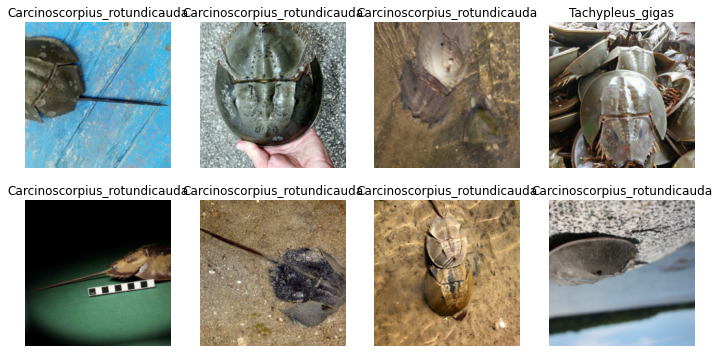

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

# **เทรน model**
ในที่นี้ผมใช้ backbone 5 อย่าง คือ 
1. VGG16
2. resneXt50
2. densenet201
3. VGG19
4. Squeezenet1_1
5. alexnet

## VGG16

In [ ]:
#load backbone
learner_VGG16 = cnn_learner(dls, models.vgg16_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

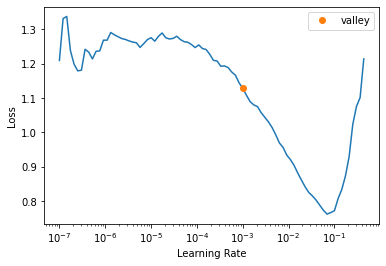

In [ ]:
# หา learning rate ที่เหมาะสม
learner_VGG16.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_VGG16.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.071252,0.657950,0.393939,0.606061,0.723404,0.596491,0.918919,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.096311,0.614038,0.356061,0.643939,0.718563,0.645161,0.810811,00:12
1,1.040016,0.603955,0.340909,0.659091,0.713376,0.674699,0.756757,00:12
2,1.025755,0.583539,0.295455,0.704545,0.745098,0.721519,0.770270,00:11
3,0.950387,0.555240,0.295455,0.704545,0.738255,0.733333,0.743243,00:15
4,0.909116,0.529984,0.265152,0.734848,0.755245,0.782609,0.729730,00:13
5,0.857591,0.513760,0.265152,0.734848,0.748201,0.800000,0.702703,00:12
6,0.807874,0.500690,0.250000,0.750000,0.759124,0.825397,0.702703,00:12
7,0.746154,0.493585,0.242424,0.757576,0.768116,0.828125,0.716216,00:12
8,0.705169,0.493353,0.242424,0.757576,0.771429,0.818182,0.729730,00:12
9,0.655958,0.497662,0.212121,0.787879,0.797101,0.859375,0.743243,00:12


In [ ]:
#save models
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_front
learner_VGG16.export("VGG16_fastai.pkl")

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_front


## resnext50

In [ ]:
from torchvision.models.resnet import resnext50_32x4d
#load backbone
learner_resnext = cnn_learner(dls, resnext50_32x4d, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()], opt_func=Adam)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0003311311302240938)

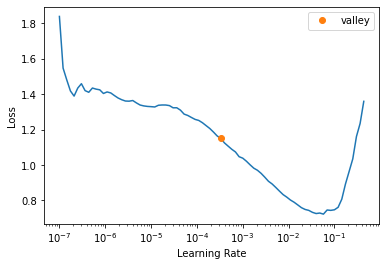

In [ ]:
learner_resnext.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
#เทรนโมเดล 20 รอบ
learner_resnext.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0003311311302240938)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.081162,1.467859,0.545455,0.454545,0.052632,1.000000,0.027027,00:08


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.075501,1.028771,0.515152,0.484848,0.209302,0.750000,0.121622,00:10
1,1.050288,0.777600,0.409091,0.590909,0.509091,0.777778,0.378378,00:10
2,0.985683,0.620767,0.340909,0.659091,0.661654,0.745763,0.594595,00:10
3,0.924661,0.560299,0.257576,0.742424,0.773333,0.763158,0.783784,00:10
4,0.922827,0.538240,0.234848,0.765152,0.800000,0.765432,0.837838,00:10
5,0.867648,0.521395,0.219697,0.780303,0.805369,0.800000,0.810811,00:10
6,0.809944,0.513741,0.204545,0.795455,0.821192,0.805195,0.837838,00:10
7,0.757305,0.511255,0.204545,0.795455,0.821192,0.805195,0.837838,00:10
8,0.727188,0.510327,0.219697,0.780303,0.810458,0.784810,0.837838,00:10
9,0.710140,0.513425,0.196970,0.803030,0.826667,0.815789,0.837838,00:10


In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model3

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model3


In [ ]:
learner_resnext.export("resnext50_fastai.pkl")

## densenet201

In [ ]:
learner_Den = vision_learner(dls, models.densenet201, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0006918309954926372)

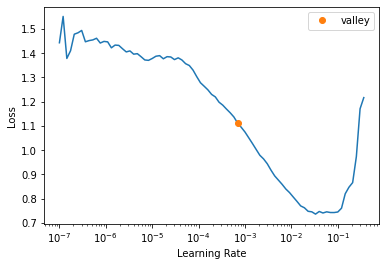

In [ ]:
learner_Den.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_Den.fine_tune(20,  freeze_epochs=1, base_lr =0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time


In [ ]:
%cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model3

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model3


In [ ]:
learner_Den.export("densenet201_fastai.pkl")

## VGG19

In [ ]:
learner_VGG19 = cnn_learner(dls, models.vgg19_bn, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

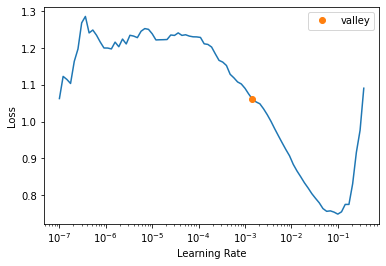

In [ ]:
learner_VGG19.lr_find() # หา learning rate ที่เหมาะสม

In [ ]:
learner_VGG19.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0014454397605732083)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.306861,0.744533,0.454545,0.545455,0.655172,0.570000,0.770270,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.029403,0.685073,0.386364,0.613636,0.679245,0.635294,0.729730,00:13
1,0.931361,0.653031,0.356061,0.643939,0.661871,0.707692,0.621622,00:13
2,0.848119,0.609338,0.310606,0.689394,0.700730,0.761905,0.648649,00:13
3,0.808401,0.535285,0.234848,0.765152,0.783217,0.811594,0.756757,00:13
4,0.757450,0.489019,0.189394,0.810606,0.829932,0.835616,0.824324,00:13
5,0.721366,0.461313,0.174242,0.825758,0.839161,0.869565,0.810811,00:13
6,0.649567,0.456202,0.181818,0.818182,0.828571,0.878788,0.783784,00:13
7,0.592703,0.479727,0.174242,0.825758,0.834532,0.892308,0.783784,00:13
8,0.550041,0.491508,0.181818,0.818182,0.826087,0.890625,0.770270,00:14
9,0.514077,0.520159,0.174242,0.825758,0.832117,0.904762,0.770270,00:13


In [ ]:
learner_VGG19.export("VGG19_fastai.pkl")

## alexnet

In [ ]:
learner_Alex = cnn_learner(dls, alexnet, metrics=[error_rate, accuracy, F1Score(), Precision(), Recall()])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575)

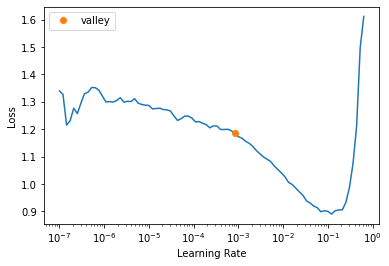

In [ ]:
learner_Alex.lr_find()

In [ ]:
learner_Alex.fine_tune(epochs=20, freeze_epochs=1, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.309652,2.242437,0.525424,0.474576,0.643678,0.474576,1.000000,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,precision_score,recall_score,time
0,1.136097,1.284064,0.474576,0.525424,0.641026,0.500000,0.892857,00:04
1,1.136917,0.931137,0.423729,0.576271,0.657534,0.533333,0.857143,00:03
2,1.142136,0.745946,0.372881,0.627119,0.676471,0.575000,0.821429,00:04
3,1.154705,0.643595,0.322034,0.677966,0.698413,0.628571,0.785714,00:03
4,1.136096,0.581246,0.237288,0.762712,0.750000,0.750000,0.750000,00:04
5,1.103300,0.557046,0.237288,0.762712,0.750000,0.750000,0.750000,00:04
6,1.071120,0.539221,0.220339,0.779661,0.763636,0.777778,0.750000,00:04
7,1.037656,0.503185,0.220339,0.779661,0.754717,0.800000,0.714286,00:03
8,1.000970,0.483617,0.203390,0.796610,0.769231,0.833333,0.714286,00:03
9,0.971690,0.485370,0.237288,0.762712,0.720000,0.818182,0.642857,00:04


In [ ]:
learner_Alex.export("alex_fastai.pkl")

# **โหลดโมเดลเพื่อทำนายผล**

## โหลดโมเดลจากที่เซฟไว้

In [ ]:
from fastbook import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

learn_inf = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_front/resnext50_fastai.pkl')

In [ ]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(valid_name='test'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(224,224)
    )

In [ ]:
PathTest = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img"
test_dls = test_dblock.dataloaders(PathTest, bs=64)

## สร้าง confusion matix

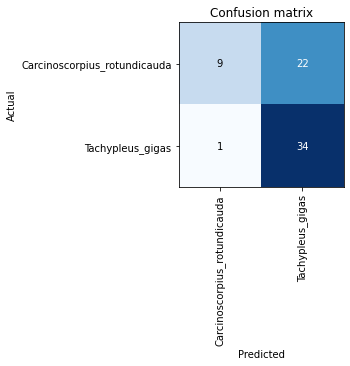

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_inf, dl=test_dls[1])
interp.plot_confusion_matrix(figsize=(5,5))

In [ ]:
interp.print_classification_report()

                              precision    recall  f1-score   support

Carcinoscorpius_rotundicauda       0.90      0.29      0.44        31
            Tachypleus_gigas       0.61      0.97      0.75        35

                    accuracy                           0.65        66
                   macro avg       0.75      0.63      0.59        66
                weighted avg       0.74      0.65      0.60        66



In [ ]:
interp.most_confused(min_val=5)

[('Carcinoscorpius_rotundicauda', 'Tachypleus_gigas', 7)]

In [ ]:
learn_inf.show_results(shuffle=True)